In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
import os
import pandas as pd


# Problem & Dataset

* Chemistry is not a mostly loved subject.
* There are various chemical compounds. The problem here is to pronounce a common name knowing its formula.  
* So, we try to learn transition: molecular_formula->common_name.
* If you want, you can replace source and target variables to predict something else (sequential)

In [2]:
molecules = pd.read_csv('molecules.tsv', sep='\t', index_col=0)
molecules = molecules[["common_name", "molecular_formula"]]
molecules = molecules.dropna()
print(len(molecules))
molecules.head(5)

76049


,common_name,molecular_formula
0,Ethyl 3-ethoxy-2-nitroacrylate,C_{7}H_{11}NO_{5}
1,N-Butyl-3-(4-fluorophenyl)-1-phenyl-1H-pyrazol...,C_{20}H_{20}FN_{3}O
2,N-Butyl-N-sec-butyl-1-benzothiophene-3-carboxa...,C_{17}H_{23}NOS
3,2-{6-[(2S)-2-Butanyl]-2-(2-methyl-2-propanyl)-...,C_{21}H_{29}N_{5}O_{3}
4,"4-Bromo-5-[(3-hydroxy-2,3-dimethyl-2-butanyl)a...",C_{13}H_{22}BrN_{3}O_{2}


In [3]:
def get_xy(x, y):
    global molecules
    return x.values, y.apply(lambda s: ["START"]+list(s)+["END"])

source_seqs, target_seqs = get_xy(molecules.molecular_formula, molecules.common_name)

In [4]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print(source, ':', "".join(target[1:-1]))

C_{7}H_{11}NO_{5} : Ethyl 3-ethoxy-2-nitroacrylate
C_{20}H_{20}FN_{3}O : N-Butyl-3-(4-fluorophenyl)-1-phenyl-1H-pyrazole-5-carboxamide
C_{17}H_{23}NOS : N-Butyl-N-sec-butyl-1-benzothiophene-3-carboxamide
C_{21}H_{29}N_{5}O_{3} : 2-{6-[(2S)-2-Butanyl]-2-(2-methyl-2-propanyl)-5,8-dioxo-5,6,7,8-tetrahydro-4H-pyrazolo[1,5-a]pyrrolo[3,4-d]pyrimidin-4-yl}-N-cyclopropylacetamide
C_{13}H_{22}BrN_{3}O_{2} : 4-Bromo-5-[(3-hydroxy-2,3-dimethyl-2-butanyl)amino]-2-propyl-3(2H)-pyridazinone


In [5]:
print(type(source_seqs))

<class 'numpy.ndarray'>


In [6]:
target_letters = list(set([token for ts in target_seqs for token in ts]))
target_letter_to_ix = {ph: i for i, ph in enumerate(target_letters)}

In [7]:
source_letters = list(set([token for word in source_seqs for token in word]))
source_letter_to_ix = {l: i for i, l in enumerate(source_letters)}

150


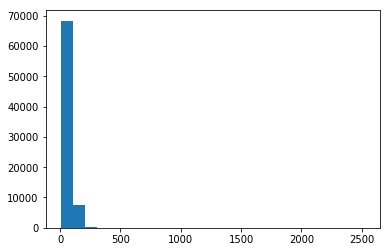

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len, target_seqs)), bins=25);

# Truncate names longer than MAX_LEN characters. This can be changed
MAX_LEN = min([150, max(list(map(len, target_seqs)))])
print(MAX_LEN)

### Cast everything from symbols into matrix of int32. Pad with -1

In [9]:
def as_matrix(sequences, token_to_i, max_len=None, PAX_ix=-1):
    """
    Converts several sequences of tokens to a matrix, edible a neural network.
    Crops at max_len(if given), pads shorter sequences with -1 or PAD_ix.
    """
    max_len = max_len or max(map(len, sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') -1
    for i, seq in enumerate(sequences):
        
        row_ix = [token_to_i.get(_, 0) for _ in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix


In [10]:
print(as_matrix(source_seqs[:3], source_letter_to_ix))

[[38 27  7 32 18 22 27  7  3  3 18 46 19 27  7 17 18 -1 -1]
 [38 27  7 16 24 18 22 27  7 16 24 18 40 46 27  7  5 18 19]
 [38 27  7  3 32 18 22 27  7 16  5 18 46 19 39 -1 -1 -1 -1]]


# Input variables

In [11]:
input_sequence = T.matrix('token sequence', 'int32')
target_sequence = T.matrix('target sequence', 'int32')

# Build NN

You will be building a model that takes token sequence and predicts next token


* Input sequence
* One-hot / embedding
* Encoder recurrent layer(s)
* Decoder recurrent layer(s)
* Softmax layer to predict probabilities

In [12]:
EMBEDDING_SIZE = 32
HIDDEN_SIZE = 256

##ENCODER
l_in = InputLayer(shape=(None, None), input_var=input_sequence)
l_mask = InputLayer(shape=(None, None), input_var=T.neq(input_sequence, -1)) 

l_emb = EmbeddingLayer(l_in, len(source_letters), EMBEDDING_SIZE)
l_rnn = LSTMLayer(l_emb, 
                  HIDDEN_SIZE, 
                  only_return_final=True, 
                  mask_input=l_mask, 
                  grad_clipping=0)

In [13]:
##DECODER
dec_in = InputLayer(shape=(None, None), input_var=target_sequence)
dec_mask = InputLayer(shape=(None, None), input_var=T.neq(target_sequence, -1))

dec_emb = EmbeddingLayer(dec_in, len(target_letters), EMBEDDING_SIZE)
dec_rnn = LSTMLayer(dec_emb, 
                    HIDDEN_SIZE,
                    cell_init=l_rnn,
                    mask_input=dec_mask, 
                    grad_clipping=0)
# WARNING! if it's lstm use cell_init, not hid_init


#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
dec_rnn_flat = reshape(dec_rnn, (-1, dec_rnn.output_shape[-1]))

decoder_flat = DenseLayer(dec_rnn_flat,
                          num_units=len(target_letters),
                          nonlinearity=lasagne.nonlinearities.softmax)

In [14]:
# Model weights
weights = get_all_params(decoder_flat, trainable=True)
#print weights

In [15]:
decoder = reshape(decoder_flat,
                  [target_sequence.shape[0], target_sequence.shape[1], -1])
#If you use dropout do not forget to create deterministic version for evaluation
decoder_output = get_output(decoder)

In [16]:
predictions_flat = decoder_output[:, :-1, :].reshape([-1, len(target_letters)])
targets = target_sequence[:, 1:].ravel()
targets_one_hot = lasagne.utils.one_hot(targets, len(target_letters))

#do not count loss for '-1' tokens
mask = T.neq(targets, -1).ravel()

loss = T.dot(mask, T.nnet.categorical_crossentropy(predictions_flat, targets_one_hot))/T.sum(mask)

updates = lasagne.updates.adam(loss, weights)

# Compiling it

In [17]:
#training
train = theano.function([input_sequence, target_sequence], 
                        loss, 
                        updates=updates, 
                        allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_sequence],
                               loss, 
                               allow_input_downcast=True)

# Generation

We now need to implement a function that generates output sequence given input.

Such function must work thusly:
```
Init:
x = input
y = ["START"]

While not_too_long:
  p(y_next|x,y) = probabilities of next letter for y
  
  y_next ~ p(y_next|x,y)
  
  y.append(y_next)
  
  if y_next == "END":
      break
```

In [18]:
#compile the function that computes probabilities for next token given previous text.
# <network output reshaped to [batch,tick,token] format>

# <a matrix [batch_i, decoder_n_tokens] of network output for last time step>
last_word_probas = decoder_output[:, -1, :]

# <a function that predicts probabilities coming after the last token>
probs = theano.function([input_sequence, target_sequence], 
                        last_word_probas,
                        allow_input_downcast=True)

In [19]:
def generate_output(seq_in,
                    output_prefix = ("START",),
                    END_token="END",
                    temperature=1,
                    sample=True):
    
    """
    Implement a function that generates output sequence given input.
    
    We recommend (but not require) you to use the pseudo-code above and inline instructions.
    """
    
    output = list(output_prefix)
    
    while True:
        next_y_probs = probs(as_matrix([seq_in], source_letter_to_ix), 
                             as_matrix([output], target_letter_to_ix))
        next_y_probs = next_y_probs**(1/temperature)
        next_y_probs = next_y_probs/np.sum(next_y_probs)

        if sample:
            next_y = np.random.choice(target_letters, p=next_y_probs[0])
        else:
            next_y = target_letters[np.argmax(next_y_probs[0])]
        
        next_y = str(next_y)
        assert type(next_y) is str, "please return token(string/character), not it's index"
        
        output.append(next_y)

        if next_y == END_token:
            break
            
    return output



# Model training

In [20]:
source_seqs = np.array(source_seqs)
target_seqs = np.array(target_seqs)

In [21]:
def sample_batch(source_seqs, target_seqs, batch_size):
    """samples a random batch of source and target sequences, batch_size elements"""
    batch_ix = np.random.randint(0, len(source_seqs), size=batch_size)
    source_seqs_batch=as_matrix(source_seqs[batch_ix], source_letter_to_ix) 
    target_seqs_batch=as_matrix(target_seqs[batch_ix], target_letter_to_ix)
    
    return source_seqs_batch, target_seqs_batch

In [22]:
from tqdm import tqdm_notebook

#total N iterations
n_epochs = 100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size = 16


for epoch in tqdm_notebook(range(n_epochs)):


    avg_cost = 0;
    
    for _ in tqdm_notebook(range(batches_per_epoch)):
        
        x, y = sample_batch(source_seqs, target_seqs, batch_size)
        avg_cost += train(x, y).mean()
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
    for i in range(5):
        ind = np.random.randint(len(source_seqs))
        print(source_seqs[ind], ':')
        print(''.join(generate_output(source_seqs[ind], sample=True)[1:-1]))
        print('C_{7}H_{11}NO_{5}', ':')
        print(''.join(generate_output("C_{7}H_{11}NO_{5}", temperature=.1)[1:-1]))



Epoch 0 average loss = 1.9775778064342857
C_{12}H_{17}BF_{3}KO_{3} :
2-Amino-3-famtazol-[4~5-dromethylethyl)henbonyl]-2-oxo-4,4-dinymethylasmothenexe-ane
C_{7}H_{11}NO_{5} :
N-(2-Methyl-2-pyridinyl)-N-(2-methyl-1H-pyrazol-4-yl)-1-phenyl-1H-pyrazol-4-yl]-1-propanyl)-1-propanoline
C_{11}H_{12}BrF_{3}N_{2}O_{2} :
7-(2,5-Dihydroxo-4-3-peren-i-yl)-4-thlorpylethyl)ethyl]-3-(9-tetro-2,68-ciparo[5,3-dimidin-6-enyl}ettanamide
C_{7}H_{11}NO_{5} :
N-[(2-Bromo-2-methyl-2-pyridinyl)-1-propyl-1H-pyrazol-4-yl)-1-propanyl)-1-propanyl)-1-propanyl)-1-propanoline
C_{17}H_{14}N_{4}O_{2} :
2-{[3-(acetyl-5-furazolo-4-thipypropyl-1(methylphenyl)amino1-3-dinechanene
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methyl-1-propyl-1-propanyl)-2-pyridinyl)-1-propanyl)-1-piperidinyl]-1,3-dihydro-2-pyridinyl]-1-propanyl]-1,3-dihydro-1H-pyrazol-4-yl]-1-pyridinyl]-1-propanoline
C_{14}H_{17}ClN_{2}O :
N-(2-Amino-2-phroro-1-foropychonydlo- H-idino-6-pyrrolidinochenydo-1H-isoprobin-2-yl)-5H-dutanocrofuletharbesuclozeinodidehecalboxa

Epoch 1 average loss = 0.9486071134700148
C_{13}H_{14}BrN_{3} :
2-Chloro-4-oxo-3-(trifluorimethyl)-2,3-diazegolo-2,3,4]oxadiazol-5-yl)etryl]-2-phenyl-1H-pyrazol-3-yl]propane
C_{7}H_{11}NO_{5} :
N-(3-Chloro-2-fluorophenyl)-1-piperazinyl)-2-pyridinecarboxylate
C_{11}H_{16}ClF_{3}N_{2}OS :
5-[4-Ethyl-1H-benzazido-5-cyacatethoxy)carbonyl)-4-piperidinenarimide
C_{7}H_{11}NO_{5} :
N-(3-Methyl-1-piperazinyl)-1-piperazinyl]methyl]-1,3-dihydro-2H-pyrazol-2-yl]-1-piperazinecarboxylate
C_{17}H_{14}BrNO_{4}S :
N-[(6-Methylbenzyl)-1-dihydro-5,3-dioxoethyl}-4-methylrophenolecahydrohenamode
C_{7}H_{11}NO_{5} :
N-[(4-Methyl-1H-pyrazol-2-yl)-1-piperazinyl)-1-piperazinyl]methyl]-1H-pyrazol-2-yl]-1-piperazinecarboxylate
C_{20}H_{24}N_{2}O_{3}S :
(3,6-Diazetyl-5-quinolinyl-4,4-dioxidabene)-NH-2,5,5-triazolazine
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-fluorophenyl)-1H-indol-2-yl)-1-piperazinecarboxylate
C_{25}H_{24}N_{4}O_{4}S :
1-Ethyl-4-fluoro-N-(4H-yd]furanyl)methyl)-1,4,3-triazol-4-yl)-5H-indole-2-carboxyami

Epoch 2 average loss = 0.8035580543598264
C_{22}H_{28}N_{3}O_{3} :
3-{2-[2,5-Dihydrobenzamine
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-fluorophenyl)-2-(2-methoxyphenyl)-1-piperazinyl]-2-(2-methyl-2-propanyl)-1-piperazinyl}-2-pyridinecarboxamide
C_{16}H_{16}O_{4} :
(2S)-3-(3-Bromophenyl)-3-(4-methyl-2,3-benzyazin-5-yl)-2-methylpyrazol-2-yl]piperidine
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-fluorophenyl)-N-(2-methyl-1-piperidinyl)-1-piperazinyl]-1-propanol
C_{15}H_{31}N :
1-(2-{[(2-Cyano-3-nadanopropinoyl]amino]piprolin-acecarboxy}atetticorecahedathide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-fluorophenyl)-1-(2-methyl-1-piperidinyl)-1-piperazinyl]-2-propanamine
C_{19}H_{22}N_{2}O_{4}S :
6-[(2,5,4,4,9,7-8-thiametan-2-yl)oxy)(1,2,3,5-tetaabutenamin(6-butane
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-fluorophenyl)-N-(2-methyl-2-propanyl)-1-piperazinyl]-N-(2-methyl-1-piperidinyl)-1-piperazinyl}-2-propanamine
C_{19}H_{26}N_{4}O_{3}S :
2-(1-Benzyl-5-o[3-(1,2,5-triazin-2-yl)-4-pyrazinyl]-4-(2-methylbenzyl)-1,3-benzazidan-2

Epoch 3 average loss = 0.7263494652677258
C_{21}H_{16}BrClN_{2}O :
1-Amino[5-(4-methyl-2-propanyl)phenyl]-1-azacacate
C_{7}H_{11}NO_{5} :
N-(3-Methoxyphenyl)-N-(2-methyl-2-propanyl)-1-piperazinyl]-N-(2-methoxyphenyl)-1-piperazinecarboxamide
C_{12}H_{17}BrFNO :
6-{[(4-Fluoroethyl)-N~5~-methyl-1-propanamine
C_{7}H_{11}NO_{5} :
N-(2-Methoxyphenyl)-2-(3-methyl-2-propanyl)-1-piperazinyl]-2-(2-methoxyphenyl)-1-piperazinecarboxamide
C_{13}H_{10}O_{2}S :
3-[(4R,3S)-2-Cyclobenzylcyclopentanecarboxylate
C_{7}H_{11}NO_{5} :
N-(2-Methoxy-2-propanyl)-1-(2-methyl-2-propanyl)-1-piperazinyl]-N-(2-methyl-2-propanyl)-1H-pyrazole-3-carboxamide
C_{20}H_{21}N_{3}O_{4}S :
5-({1-[3-(Benzyloxy)phenyl]carbamethifyrramide
C_{7}H_{11}NO_{5} :
N-(2-Methoxy-2-propanyl)-N-[(2-methyl-2-propanyl)sulfanyl]-1-piperazinyl}ethanone
C_{20}H_{27}ClN_{2}O_{4} :
1-[(2R)-3-{[3-(3-Fluorophenyl)propyl]-2H-1,2,4]thiadiazol-2-yl]cecaamate
C_{7}H_{11}NO_{5} :
N-(2-Methoxy-2-propanyl)-1-(2-methyl-2-propanyl)-1-piperazinyl]-2-propan

Epoch 4 average loss = 0.6869662529548022
C_{29}H_{30}F_{3}N_{3}O_{2} :
3-Methoxa-propyl-4-(2-pyrrolidinone
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-1-(2-methyl-1H-pyrazol-5-yl)-1-propanamine
C_{10}H_{8}BrClN_{2}O :
N-Methyl-4-phenyl-1-(2-methoxyethyl)-N-(2-propoxy-propylamino)-2,4-dihydro-3-pertazi[n,3-4]pyrimidine-2(5(dine
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-1-(2-methyl-1H-pyrazol-5-yl)-1-piperazinecarboxamide
C_{18}H_{26}N_{2}O_{4} :
N-[4-(3,6-Dibromophenyl)-2-oxo-1,2,5-trimethylphenyl]acrylamide hydrochloride (1:3)
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-1-(2-methyl-1H-pyrazol-4-yl)-1-piperazinecarboxamide
C_{16}H_{14}ClF_{2}NO_{2}S :
N-[1-(Dimethylamino)ethyl]-N-methylethanamine
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-2-(3-methylphenyl)-1-piperazinecarboxamide
C_{19}H_{18}N_{4}O_{6} :
N~1~-(sulflamino)yl-9-(2-methoxypropyl)amino]-4-phenylalaninamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-1-(2-methyl-1H-pyrazol-4-yl)-1,3-dihydro-1H-pyrrol

Epoch 5 average loss = 0.6646982450448063
C_{19}H_{21}FN_{2}O_{4}S :
N-[(E)-(3-Chloro-1,N-dioxo-7-(methylsulfanyl)oxy]-3-(4-thiophenyl)-5-methoxy-3-oxo-2,4,5-dimethyl-1,3,4,5-tetrahydro-5H-quinoxilonic acid
C_{7}H_{11}NO_{5} :
N-[(2-Chloro-4-methylphenyl)sulfonyl]-1-piperazinyl}-2-(2-methyl-2-propanyl)-1,3-dihydro-2H-pyrrolo[3,4-d]pyrimidine-6-carboxylate
C_{19}H_{30}N_{2}O_{5} :
N~1~-N-Allyloxy]-2-(2-hydroxyphenyl)ethanone
C_{7}H_{11}NO_{5} :
N-[(2-Chloro-4-methylphenyl)sulfonyl]-1-piperazinyl}-N-(2-methyl-2-propanyl)-1,3-thiazol-2-yl]-1-propanamine
C_{19}H_{18}BrNO_{2} :
1-[1-(1H-Imidazol-5-yl)-1-phenyl-2-propanyl]-(4-pyridinyl)sulfanyl]-1,4-dioxoacetamide
C_{7}H_{11}NO_{5} :
N-[(2-Chloro-4-methylphenyl)amino]-2-oxoethyl}-1-propanamine
C_{13}H_{11}Cl_{2}N_{3}O_{2} :
(4Z)-3O,2'',6'-Do7-(3-Fluorophenyl)-N'-(propyl-2-methoxyphenyl]-1Ha-inolo-2,4-dioxo[3,3-thiazol-2-yl]sulfanyl}acrylate
C_{7}H_{11}NO_{5} :
N-[(2-Chloro-4-methylphenyl)amino]-2-oxoethyl (2S)-2-(4-methylphenyl)-1,3,4-oxadia

Epoch 6 average loss = 0.6437836554126173
C_{15}H_{18}Br_{2}N_{4}O_{2} :
5-(4-Fluorophenyl)-N-{2-[(4R)-Acatyl-5al,7a,5aR,9bS,16R,10S)-6,9R)-6-(3,46-1,7,9diacetahyrro-3-furanoyl]-1,2,4,5-tetrahydro-1,3-benzothiazin-2(1H)-one
C_{7}H_{11}NO_{5} :
N-(3-Amino-2-propanyl)-N-[(2-methyl-2-propanyl)oxy]carbonyl}-2-propanamine
C_{10}H_{19}F_{2}NO :
2,N-Diethyl-4-(3-methoxpeneyl)benzoite
C_{7}H_{11}NO_{5} :
N-(3-Chloro-2-methylphenyl)-2-(3-methoxyphenyl)-2-propanamine
C_{26}H_{20}ClN_{5}O_{3}S :
Benzyl [1,2,3]triazino[1,2-a]isditen-5-ylmethyl)-5,6,8,7-tetramethylbenzenesulfonamide
C_{7}H_{11}NO_{5} :
N-(3-Chloro-2-methylphenyl)-N-[(2-methyl-2-propanyl)oxy]carbonyl}-2-propanamine
C_{13}H_{28}N_{2}O :
2-[4-(Bromomethyl)-1-pyrazolidinyl]-N-methylbenzamide
C_{7}H_{11}NO_{5} :
N-(3-Chloro-2-methylphenyl)-N-[(2-methyl-2-propanyl)oxy]carbonyl}-N-methyl-1-propanamine
C_{13}H_{22}N_{2}O_{2} :
1-[(Isobutyl-2-propanyl)-hydrasonyl)methyl]-3-propanone
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-2-[(2-meth

Epoch 7 average loss = 0.622332914690206
C_{15}H_{12}ClNO_{3} :
3-[(3,5-Dimethoxyphenyl](3-oxo-2,4-oxazole-4-carboxylalino]ethyl 3'-hydroxy-6-methylquinoline
C_{7}H_{11}NO_{5} :
2-(2-Methyl-2-pyridinyl)-1-(2-methyl-2-propanyl)-1,3-thiazol-2-yl]-2-propanamine
C_{17}H_{21}N_{3}O_{6} :
3-Nitro-2-({4-[(3-hydroxyphenyl)amino]benzoic aclace
C_{7}H_{11}NO_{5} :
N-(2-Methyl-2-pyridinyl)-N-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{14}H_{10}Br_{2}ClFO :
1-(E,3-Dimethyl-1-piperidinyl)-3-(2-thienyl)ethanone
C_{7}H_{11}NO_{5} :
1-(2-Methyl-2-pyridinyl)-1-(2-methyl-2-propanyl)-1,3-thiazol-2-yl]-1-propanamine
C_{27}H_{30}F_{3}N_{5}O :
N-Methyl-N-[2-(2-methyl-3-piperidinyl)ethyl]-6-pyrimidinecarboxylate
C_{7}H_{11}NO_{5} :
N-(2-Methyl-2-pyridinyl)-N-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{13}H_{24}N_{2}O_{3}S :
Ethyl {[(4E)-5-(3-chloro-3-fluorophenyl)phenyl]ethanamine
C_{7}H_{11}NO_{5} :
N-(2-Methyl-2-pyridinyl)-N-(2-methyl-2-propanyl)-1,3-thiazol-2-yl]-2-propanamine


Epoch 8 average loss = 0.6123036645968366
C_{16}H_{17}ClN_{2}O :
(4E)-2-Ethyl-N~6~-(2-methoxyphenyl)-N-methyl-1-benzeneburane
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-N-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{17}H_{27}ClN_{2}O_{3} :
3-(4-Fluorophenyl)-N-[4-(propylsulfanyl)phenyl]-1,3-thiazol-3-yl]methanethioamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-N-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{12}H_{15}Cl_{2}NO :
Methyl N-{[4-(1H-pyrazol-1-ylmethyl)-1,2,4-oxadiazol-3-yl]methoxy}-4-ethoxybutylricecaniamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-N-[(2-methyl-2-propanyl)amino]-1-propanamine
C_{22}H_{20}F_{3}NO_{2}S :
N~2~-(4-Chloro-4-methoxyphenyl)-1-{4-[(2-methylpentyl)thieno[1,2-d]pyrimidin-3-yl]carbonyl}glycinamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-N-[(2-methyl-1H-pyrazol-4-yl)methyl]-1-propanamine
C_{15}H_{14}N_{2}O_{4} :
2-{cyclopropyl(4-methyl-2-oxo-3,3-dihydro-1H-sulfinyl]methyl}methanone
C_{7}H_{11}NO_{5} :
N-(2-Chloro-

Epoch 9 average loss = 0.6007784585630686
C_{21}H_{23}N_{3}O_{3} :
3-Methyl-N-(4-methylbutyl)-4-phenyl-4,4-dihydroimidazo[2,1-a]pyrazine
C_{7}H_{11}NO_{5} :
2-(2-Chlorophenyl)-2-[(2-methyl-2-propanyl)amino]-2-oxoethyl (2-methyl-2-propanyl)amino]benzoate
C_{9}H_{14}N_{4}O_{3}S :
N-(1-{[2-(3,4-Dimethyl-1-benzofuran-1-yl)ethyl]carbamoyl}-3-pyrrolidinecarboxylic acid
C_{7}H_{11}NO_{5} :
2-[(2-Chloro-4-methylphenyl)amino]-2-oxoethyl 2-methyl-2-propanyl)-N-methyl-1,3-thiazole-5-carboxylate
C_{14}H_{20}ClF_{2}NO_{2}S :
Ethyl 2-ethyl-4-(4-fluorobenzyl)benzoyl]oxy}propanoic acid
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-N-[(2-methyl-2-propanyl)amino]-2-oxoethyl (2-methyl-2-propanyl)amino]benzoate
C_{8}H_{8}N_{2}O_{2} :
N-[2-(Bromomethyl)-2-oxoethyl]-N-(2-propoxybenzyl)cyclopropyl}-1,4-dimethyl-1H,4H)-quinoline-3,2(7H)-dione
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-N-(2-methyl-2-propanyl)-1,3-dihydro-2H-pyrrol-2-one
C_{21}H_{21}BrN_{2}O_{3}S :
5-[(5-Bromo-2-furyl)methyl]glyciceridin

Epoch 10 average loss = 0.5983371115937658
C_{14}H_{19}ClO_{3} :
N-[(2E)-N-(2-Methyl-2-butonyl)-1H-isoindol-7-yl]ethanone
C_{7}H_{11}NO_{5} :
2-(2-Chlorophenyl)-N-(3-methyl-1-piperazinyl)-2-propanol
C_{18}H_{22}N_{2}O_{2}S :
6-(3,4-Dimethyl-1,3-thiazol-1-yl)-N-(2-oxo-2-pyrrolidinyl)benzamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-N-(2-methoxyethyl)-1-propanamine
C_{16}H_{23}FN_{2}O_{2} :
2-Cyclo[2.2.1]heptyl-5-(3-fluoro-1-piperidinyl)butanoate
C_{7}H_{11}NO_{5} :
2-(2-Methoxy-3-methylphenyl)-N-(2-methyl-2-propanyl)-1,3-thiazole-5-carboxamide
C_{13}H_{26}N_{2}O :
2-[(3,4-Diaminopyrazolo[3,3-d]pyridin-6-ylmethyl)amino]ethanol
C_{7}H_{11}NO_{5} :
1-(2-Bromo-2-methoxyphenyl)-N-(2-methoxyethyl)-1-propanol
C_{13}H_{18}FNO_{4}S :
N-(7-Chloro-5-pyrimidinyl)-2-(1-hydroxy-3-fluorophenyl)-2(methyl-10-methoxy-1-neta-D-glucoylthionide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-N-(2-methyl-2-propanyl)-1-propanol


Epoch 11 average loss = 0.5881992569563199
C_{29}H_{36}N_{2}O_{6} :
3-Fluoro-3-[(4-nitrophenyl)amino]-2-oxoethyl 1-(1-piperidinyl)-2-(4-oxo-1,3-oxazolidin-3-yl)methylene]acetohydrazide
C_{7}H_{11}NO_{5} :
2-[(2-Methyl-2-propanyl)oxy]-3-methyl-1-piperidinecarboxamide
C_{17}H_{17}NO :
2-{[5-[Dimethyl(3,4-dimethylphenyl)sulfanyl]propyl}amino)-2-methylbutanoic acid
C_{7}H_{11}NO_{5} :
N-(2-Chloro-2-methylphenyl)-N-(2-methyl-2-propanyl)-2-propanamine
C_{12}H_{11}ClN_{2}O_{5}S :
3-{6-[(2CEthyl-3-methyl-1-piperazinyl)sulfinyl]methyl}sulfanyl)-N-(2-methoxyethoxy)-2-pyridinamine
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-N-[2-(4-methylphenyl)-1,3-thiazol-2-yl]-1-propanamine
C_{18}H_{20}N_{2}O_{3} :
[2-(2-Pyridinyl)-4-oxo-2,4-dihydro-1H-imidazol-4-yl]3aninine
C_{7}H_{11}NO_{5} :
N-[2-(2-Methyl-2-propanyl)-1,3-thiazol-2-yl]-2-propanamine
C_{22}H_{39}F_{3}N_{4}O_{7}S :
N-Methyl-N-[3-(1-piperidinylmethyl)phenyl]tetrahydrazide
C_{7}H_{11}NO_{5} :
N-[2-(2-Methyl-2-propanyl)-1,3-thiazol-2-yl]-2-p

Epoch 12 average loss = 0.5778424174495501
C_{15}H_{22}N_{2}OS :
N-{2-[(1R)-1-(1,4-Diethyl-1H-pyrazol-1-yl)ethyl]oxy}-1H-imidazole-5-carboxylic acid
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-N-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{12}H_{12}BrN_{3}O_{3} :
6-(1,1-Dioxidotyclopentyl)-6-methyl-2,9-dihydro-4H-2,6-benzothiazol-5(3H)-one
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(1-methyl-1H-pyrazol-4-yl)-1,3-thiazole-4-carboxamide
C_{24}H_{28}N_{4}O_{6} :
2-Bromo-3-{[4-hydroxy-2-(2-naphthyl)-1,3,4-thiadiazol-2(5H)-ylidene)methyl]isonicotinamide
C_{7}H_{11}NO_{5} :
1-(2-Chloro-4-methylphenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{14}H_{24}N_{4} :
3-[(2E)-5-(4,5-dimethylphenyl)-2-(4-phenyl-1H-benzimidazol-2-yl)ethyl]propanamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{19}H_{19}Cl_{2}NO_{5} :
1-(1-Cyclohexen-4-ylmethyl)-1H-pyrazole-4-carboxylic acid
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylph

Epoch 13 average loss = 0.5700017840033204
C_{8}H_{8}ClNO_{2}S_{2} :
N-Methyl-N-[({(2E)-2-(3-bromo-1-isoquroxanesylidene)ethyl](4-methoxy-2-propanyl)oxy]-3-pyridinamine
C_{7}H_{11}NO_{5} :
N-(2-Methyl-2-propanyl)-N-(2-methyl-2-propanyl)-1,3-thiazole-5-carboxamide
C_{20}H_{18}N_{6}O_{2}S :
N-(7-Chloro-3-thienyl)-1,1,3,3-tetradecahydro-7-[(E)-(5,7-dimethyl-1,4-benzodioxol-1-yl)methylene]amino}benzonitoic acid hydrochloride (1:1)
C_{7}H_{11}NO_{5} :
N-(2-Methoxyethyl)-N-(2-methyl-2-propanyl)-1,3-thiazole-5-carboxamide
C_{15}H_{12}F_{3}NO_{5} :
N-[(E)-{[3-(6-Methoxy-3-piperidinyl)-4-pyridinyl]amino}-2-oxoethylidene]hydrazino}ethyl)-4,5-dimethylbenzoate
C_{7}H_{11}NO_{5} :
N-(2-Methoxyethyl)-N-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{17}H_{24}N_{4}O_{2} :
N-[(1E)-N-Allyl-hexylsilyloxy,2-bromet-2-ene
C_{7}H_{11}NO_{5} :
2-(2-Methoxyethyl)-1-piperazinyl (2-methyl-2-propanyl)amino]-2-propanol
C_{16}H_{15}BrClNO :
6-({5-Chloro-N-[(1-methyl-1H-pyrazol-1-yl)methyl]-2,3-dihydro-4-quinol

Epoch 14 average loss = 0.5670676655775472
C_{12}H_{12}N_{6}OS :
[4-(2H-Imidazol-4-yl)ethyl]carbamoyl}-2-cyclopropylbenzamide
C_{7}H_{11}NO_{5} :
2-(3-Chloro-4-fluorophenyl)-2-(4-methylphenyl)-2-methyl-1-propanamine
C_{10}H_{12}Br_{2}N_{2}O_{2} :
(2R)-1-[(1-Methyl-1H-pyrazol-4-yl)methyl]-3-phenyl-1H-imidazol-4-amine
C_{7}H_{11}NO_{5} :
1-(2-Methoxyphenyl)-N-(2-methyl-2-propanyl)-1-propanamine
C_{15}H_{21}NO_{4} :
Methyl{3-[(4-chlorobenzyl)amino]-12-amino-2-pyrrolidinecarboxylate
C_{7}H_{11}NO_{5} :
2-(3-Chlorophenyl)-2-(4-methylphenyl)-2-(4-methylphenyl)-1,3-thiazole-4-carboxamide
C_{21}H_{21}FN_{4}O :
1-{[3-(3-Bromophenyl)ethyl]carbamoyl}-3-chlorobenzoate
C_{7}H_{11}NO_{5} :
1-(2-Chloro-4-methoxyphenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{17}H_{22}N_{2}O :
Ethyl 1-[(2-cyano3-2-propanyl)sulfonyl]propanoic acid
C_{7}H_{11}NO_{5} :
N-[(2-Methyl-2-propanyl)amino]-2-oxoethyl 3-(4-fluorophenyl)-1-propanone


Epoch 15 average loss = 0.5580802395728317
C_{19}H_{18}ClN_{3}O_{3}S :
2-[2-(Chloromethyl)cyclobutanoyl]-3-chlorobenzamide
C_{7}H_{11}NO_{5} :
1-(2-Chloro-4-methoxyphenyl)-2-(2-fluorophenyl)-2-methyl-1H-pyrazole-4-carboxamide
C_{19}H_{21}N_{3}O_{4}S :
5-Hydroxy-5-{[1,4,4]triazino[3,5-b]pyrazol-9-yl(2-cyclohexen-1-yl)carbonyl]amino}phenonitrile
C_{7}H_{11}NO_{5} :
2-(2-Chloro-4-methoxyphenyl)-2-(2-methoxyphenyl)-2-methyl-1H-pyrazole-4-carboxamide
C_{11}H_{11}F_{3}N_{4} :
1-(2,5-Difluorophenyl)-N-(2-pentanyl)-N,4-dimethyl-1-sulfanylpropanamide
C_{7}H_{11}NO_{5} :
2-(2-Chlorophenyl)-2-(2-fluorophenyl)-2-(2-methoxyphenyl)-1H-pyrazole-4-carboxamide
C_{16}H_{18}N_{2}O_{3} :
3-(3-Methoxyphenyl)-2-(2-fluorophenyl)ethanamine
C_{7}H_{11}NO_{5} :
1-(3-Chloro-4-methoxyphenyl)-2-(2-methoxyphenyl)-2-(2-methoxyethyl)-1H-pyrrole-2-carboxamide
C_{15}H_{22}N_{2}O_{3} :
2-Bromo-N-[4-(2-methyl-2-propanyl)-1-piperazinyl]-3-hydroxy-3-methylcyclohexanamine
C_{7}H_{11}NO_{5} :
N-(2-Methoxyphenyl)-2-(2-pyridin

Epoch 16 average loss = 0.5516258677497483
C_{24}H_{21}FN_{4}O_{4}S :
2-Methoxy-N-[1-(methylsurfonyl)phenyl]acetamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(3-methyl-1-piperidinyl)-1-propanamine
C_{21}H_{21}N_{3}O_{5}S :
2-{[2-(1,3-Benzodioxol-5-yl)-4,5-dibismero-2H-terazol-5-yl]propanoyl}-N-[2-(isopropylsulfanyl)butyl]-5-hexanaminiumimide
C_{7}H_{11}NO_{5} :
2-(2-Methyl-2-propanyl)-2-(3-methyl-1-piperazinyl)-1-propanol
C_{17}H_{28}N_{2}O_{2} :
1-{4-[(2-Methyl-2-propanyl)oxy]phenyl}-4-methyl-2-oxopropanomidamide
C_{7}H_{11}NO_{5} :
N-(2-Methyl-2-propanyl)-N-(2-methyl-2-propanyl)-1-propanamine
C_{15}H_{31}NO_{3} :
Methyl 2-{[(1-methylcalbamothioyl)amino]acetyl}amino)butanate
C_{7}H_{11}NO_{5} :
2-(3-Chloro-4-methylphenyl)-2-(3-methyl-1-piperazinyl)-2-propanol
C_{17}H_{19}ClN_{4}O_{2} :
(2R)-1-{[(2-Propyl-1H-hydro-1-benzofuran-7-yl)amino]methyl}-1,3-benzodioxole
C_{7}H_{11}NO_{5} :
N-(2-Methyl-2-propanyl)-N-(2-methyl-2-propanyl)-1-propanamine


Epoch 17 average loss = 0.5440411738319887
C_{21}H_{29}FN_{2}O_{2} :
(3S)-4-[(2-Methoxyethyl)hexanoyl]carbamoyl}-1-(1,2,5-trimethyl-1H-pyrazol-1-yl)-N-(2-propyn-1-ylmethyl)glycinamide
C_{7}H_{11}NO_{5} :
2-(2-Chloro-4-fluorophenyl)-2-(2-methyl-2-propanyl)-1H-pyrazole-4-carboxylic acid
C_{14}H_{22}N_{2}OS :
1-(1-Amino-2-butanyl)-N~2~-[2-(3-iodophenyl)ethyl]aniline
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(2-methyl-2-propanyl)-1H-pyrazole-4-carboxamide
C_{16}H_{17}ClOS :
5-Ethyl-3-(2-bromophenyl)-1H-benzimidazole
C_{7}H_{11}NO_{5} :
2-(2-Methoxyethyl)-1-piperidinyl (2-methyl-2-propanyl)amino]benzamide
C_{16}H_{27}N_{3}O :
7-Methyl-3,3-dimethylthieno[2,3-d]pyrimidine-5-sulfonamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-fluorophenyl)-2-(2-methyl-2-propanyl)benzamide
C_{14}H_{18}F_{3}NOS :
2,2-Dimethyl-N~1~-(3-piperidinylmethyl)benzamide
C_{7}H_{11}NO_{5} :
2-(2-Chloro-4-fluorophenyl)-2-(2-methyl-2-propanyl)-1H-pyrazole-4-carboxylic acid


Epoch 18 average loss = 0.5347664061220082
C_{16}H_{22}BrNO_{2}S :
N-{[4-(3-Methoxypropyl)-3,5-dimethyl-1H-pyrazol-4-yl]methyl}-1-propanamine
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{9}H_{12}BrN_{3}OS :
2-(1-Azepanyl)-2-methyl-2-propanol
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(4-methylphenyl)-1,3-thiazole-4-carboxamide
C_{15}H_{14}BrClO :
Methyl (2S,3aS,6aR)-4-{[(S)-(4-chlorophenyl)amino]methylene}-2,3-dihydro-1,4-benzoxazepin-8-amine
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxamide
C_{12}H_{20}N_{4} :
Euta
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(2-methoxyethyl)-1,3-thiazole-4-carboxamide
C_{10}H_{18}N_{2}O_{4}S :
(2S)-3-Cyclopropyl-3-{2-[(2-bromo-5-nitrophenyl)amino]-2-oxoethyl}benzoflooremidene
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(2-methoxyethyl)-1,3-thiazole-4-carboxamide


Epoch 19 average loss = 0.5299654523003001
C_{12}H_{23}NO_{4} :
(1-Cyclopentyl-1(1H)-quinolinyl)[(3R)-3-pyrrolidinylmethyl)(methyl)amino]acetic acid
C_{7}H_{11}NO_{5} :
(2S)-2-(4-Bromo-2-methoxyphenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-5-carboxamide
C_{22}H_{32}N_{4}O_{5}S_{2} :
4-Amino-N-(3,3,4-trimethyl-1-piperidinyl)-N-(5-methyl-2-pyridinyl)cyclopropanecarboxamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(4-methylphenyl)-1,2-dihydro-3-pyridinecarboxamide
C_{17}H_{19}N_{3}O_{3} :
(2E)-3-(4-Benzyl-3-chloro-4-chlorophenyl)-2-(4-methoxyphenyl)-1H-pyrazole-3-carboxamide
C_{7}H_{11}NO_{5} :
N-(2-Amino-2-oxoethyl)-2-methyl-1-pentanamine
C_{14}H_{24}N_{4}O :
1-(2-Furoyl)-2,2-dimethyl-N-methyl-2-thioxo-1,3-thiazolidin-4-one
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-5-carboxamide
C_{21}H_{23}N_{3}O_{4}S_{2} :
N-Benzyl-2-[(3,4-dimethylphenoxy)ic acatrilonicotinate asimide
C_{7}H_{11}NO_{5} :
N-(2-Cyano-2-pyridinyl)-2-(4-methylphenyl)-1,2-d

Epoch 20 average loss = 0.529036500302744
C_{16}H_{22}ClF_{2}N :
N-(2-Aminopropyl)-N-{1-methyl-1-(2-pyridinyl)ethyl]urea
C_{7}H_{11}NO_{5} :
N-[(1S)-1-(3-Bromophenyl)-1,3-thiazol-2-yl]-2-methyl-1-propanamine
C_{22}H_{24}N_{4}O_{3} :
N-(4-Fluorobenzyl)-2-sulfanylbenzamide
C_{7}H_{11}NO_{5} :
1-(2-Chloro-4-fluorophenyl)-2-(3-methyl-1-piperidinyl)-1-propanone
C_{13}H_{18}N_{4}O_{3}S :
4-Chloro-phenyl {N-({[N-(3-bromo-4-fluorobenzyl)imidohydecyn]oxy]-1-piperazinyl]-4-quinazolinecarboxylate
C_{7}H_{11}NO_{5} :
1-(2-Chloro-4-fluorophenyl)-N-methyl-1-butanamine
C_{18}H_{19}F_{3}N_{2}O_{4}S :
N-Cyclopropyl-2,5-dimethyl-N-[5-(2-phenylethyl)-beta-alanyl]-D-alanine
C_{7}H_{11}NO_{5} :
2-(2-Bromo-4-methoxyphenyl)-2-(2-methoxyphenyl)-1,3-oxazole-5-carboxylic acid
C_{14}H_{23}ClN_{2}O_{5}S :
N'-[(E)-(2-Phenylethyl)amino}-2-oxoethyl thiouonanic acid fluorete
C_{7}H_{11}NO_{5} :
3-[(3-Chloro-4-fluorophenyl)amino]-2-oxoethyl (2-methyl-2-propanyl)amino]acetate


Epoch 21 average loss = 0.5293859817455203
C_{20}H_{35}NO :
N-[1-(Butylsulfanyl)-3-propyn-1-yl]hexahydro-2-thiophenecarboxamide
C_{7}H_{11}NO_{5} :
2-(2-Chloro-4-methylphenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-5-carboxylic acid
C_{10}H_{16}N_{4}O_{4}S :
2-[(1,1-Dioxido-2,3-dihydro-4-benzothiophen-2-yl)methyl]-N-ethylacetamide
C_{7}H_{11}NO_{5} :
1-(2-Chloro-4-fluorophenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-5-carboxylic acid
C_{9}H_{4}BrCl_{3}N_{4}O :
N-(3,5-Dichlorophenyl)-1-methyl-1-butanamine
C_{7}H_{11}NO_{5} :
2-(2-Chloro-4-fluorophenyl)-2-(2-methyl-2-propanyl)-1,3-thiazol-2-amine
C_{17}H_{19}N_{3}O_{2}S :
N-{1-[5-(Hydroxymethyl)phenoxy]phenyl}-N-methylsulfonyl]alaninamide
C_{7}H_{11}NO_{5} :
1-(2-Chloro-4-methylphenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-5-carboxylic acid
C_{13}H_{20}BrFN_{2}O :
N-[4-Cyclopentyl-2-(3-piperidinyl)-3-pyridinyl]methanamine
C_{7}H_{11}NO_{5} :
1-(2-Chloro-4-fluorophenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole


Epoch 22 average loss = 0.5217812466722198
C_{14}H_{17}ClFN_{3} :
5,6-Dioxo-5,1''-dihydro-3H-indeno[2,3-c]quinolin-6(5H)-one
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methoxyphenyl)-2-(3-methoxyphenyl)acetamide
C_{8}H_{14}ClN_{3} :
3-Methoxy-2-O-(2,3,6-trimethoxybenzoyl)-1-benzofuran-2-ium
C_{7}H_{11}NO_{5} :
2-[(2-Methoxyphenyl)amino]-2-oxoethyl (2E)-3-(2-methoxyphenyl)acrylate
C_{13}H_{22}N_{2}S :
N~2~-(1,3-Diphenylcyclobutyl)-N'-ethoxy-4-pyrimidinecarboxamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methoxyphenyl)-2-(2-methoxyethyl)-1H-pyrazole-4-carboxamide
C_{16}H_{27}NOS :
5-[(5-Hydrazino-2-pyrimidinyl)methyl]-N-methylacetamide
C_{7}H_{11}NO_{5} :
(2S)-2-(2,3-Dihydro-1,4-benzodioxin-6-yl)-N-(2-methoxyethyl)-2-propanamine
C_{21}H_{16}N_{2}O_{2}S_{3} :
5-[3-(3aH-Benzofuran-2-yl)-1-[2-oxo-2-phenyl-2-propanyl]-1H-pyrazolo[3,4-d]pyrimidin-5(4H)-ylidene]acetohydrazide
C_{7}H_{11}NO_{5} :
3-(2-Methoxyphenyl)-1-(2-methoxyethyl)-1H-pyrazole-4-carboxamide


Epoch 23 average loss = 0.5206305054486711
C_{20}H_{13}BrClN_{5}O_{3} :
1-(3,4-Dichlorophenyl)-2-{[2-(4-methylphenyl)-1H-1,2,4-triazol-3-yl]sulfanyl}acetamide
C_{7}H_{11}NO_{5} :
5-(3-Chloro-4-methylphenyl)-2-methyl-2-propen-1-ol
C_{22}H_{20}ClFN_{4}O_{2}S :
N-{3-[(2-Ethoxy-4,5-dimethyl-2-furyl)methyl]-2-piperidinyl}propanamide
C_{7}H_{11}NO_{5} :
2-(2-Methyl-2-propanyl)-1-piperidinecarboxylic acid
C_{15}H_{20}F_{3}NO :
N-Cyclohexylethyr (methylamino)acetate hydrochloride (1:1)
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(3-methyl-1-piperidinyl)ethanamine
C_{21}H_{19}Cl_{3}N_{2}O_{3} :
N-[2-(3,4-Dimethoxyphenyl)-6-methyl-2-pyridinyl]-4-(methylsulfonyl)-2-pyrrolidinecarboxamide
C_{7}H_{11}NO_{5} :
2-(3-Chloro-4-methylphenyl)-2-(3-methylphenyl)-1-propanamine
C_{15}H_{19}FN_{4}O :
3-[(2-Aminobenzyl)oxy]benzoic acid
C_{7}H_{11}NO_{5} :
1-[(2-Methyl-2-propanyl)oxy]-3-methyl-1-piperidinecarboxylic acid


Epoch 24 average loss = 0.5138999234738852
C_{11}H_{22}N_{2}O_{2} :
1-{[(1-ethyl-1H-imidazol-2-yl)carbonyl]glycyl}-1,3-thiazole-4-carbonitrile
C_{7}H_{11}NO_{5} :
2-(2-Methyl-2-propanyl)-1-(2-methyl-2-propanyl)-1H-pyrazole-4-carboxylic acid
C_{15}H_{23}N_{5} :
N'-[(Z)-(2-Ethylphenyl)methylene]-2,6-dihydro-3H-1,4,4-triazole-4-sulfonamide
C_{7}H_{11}NO_{5} :
2-(2-Chloro-4-fluorophenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole
C_{15}H_{30}N_{2}O_{2} :
7-Amino-6,7a,7,7a-trimethyl-2,5,6,7-tetrahydro[1,3,4]thiadiazolo[3,4-a]pyrazine-6-carboxylic acid
C_{7}H_{11}NO_{5} :
2-(2-Methyl-2-propanyl)-1-(2-methyl-2-propanyl)-1,3-thiazole-4-carbonitrile
C_{25}H_{37}NO_{6} :
1-(3-Fluorophenyl)-2-[({2-[2-(phenoxycarbonylamino)-2-oxoethyl]-1-pyrrolidinyl}methyl)-2-butanol
C_{7}H_{11}NO_{5} :
2-(2-Chloro-4-fluorophenyl)-2-(2-methyl-2-propanyl)-1,3-thiazole
C_{13}H_{18}BrNO_{3} :
(1S,2E)-2-[5-Hydrazino-4-(1-piperidinyl)ethyl]piperazine
C_{7}H_{11}NO_{5} :
2-(2-Amino-2-propanyl)-3-(2-methyl-2-propanyl)-1,3-thi

Epoch 25 average loss = 0.5130262657421168
C_{12}H_{18}N_{2}O_{4} :
2-Bromo-N-[2-(2-fluorophenyl)-2-hydrazinobutanone hydrochloride (1:1)
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(2-methyl-2-propanyl)-1-propanamine
C_{13}H_{12}F_{3}NO_{2} :
Methyl 2-deoxy-3-hydroxy-3-fluoro-4-methoxy-3-pyrrolidinecarboxylate
C_{7}H_{11}NO_{5} :
2-(2-Bromophenyl)-2-(2-methyl-2-propanyl)-1,2,4-oxadiazole
C_{15}H_{21}N_{3}OS :
2-[(1E)-1,1-Dioxidotetrahydro-2H-pyran-3-yl]methanesulfonamide
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-methyl-2-propanamine
C_{18}H_{19}N_{5}O_{4} :
4-Hydroxy-4-[E)-2-(2-methyl-2-propanyl)-2-pyrimidinyl]-N-[1-(2-pyrimidinylmethoxy)phenyl]acetamide
C_{7}H_{11}NO_{5} :
2-(2-Methoxyethyl)-1-(2-methyl-2-propanyl)-1,2,4-oxadiazole
C_{15}H_{17}N_{5}O :
4-{[(4-Amino-2-methylphenyl)sulfanyl]methyl}pyrrolidine
C_{7}H_{11}NO_{5} :
2-(2-Methoxyethyl)-2-(2-methyl-2-propanyl)-1,3-thiazole-5-carboxamide


Epoch 26 average loss = 0.5112156044536383
C_{16}H_{17}N_{5}O_{2} :
2-Hydroxybenzo[1,1-b][1,2,3]thiazolo[3,2-b][2,4,7,10-hexamethyl-6-quinolinecarbonitrile
C_{7}H_{11}NO_{5} :
2-[(2-Methoxyethyl)amino]-2-(2-methyl-2-propanyl)-1-propanol
C_{24}H_{22}N_{4}O_{2} :
N-[2-(4-Ethoxy-5-nitrophenyl)-6-(1H-indol-3-yl)ethyl]-3-(1-piperazinyl)-7-(1-piperidinyl)-2-propanamine
C_{7}H_{11}NO_{5} :
2-(2-Methoxyethoxy)-N-(2-methyl-2-propanyl)-1-propanamine
C_{22}H_{14}ClFN_{4}O_{2} :
5-[6-(3,4-Dimethoxyphenyl)-2-piperazinyl]-N,N-bicyclo[4.2.2]octane-2-carboxamide
C_{7}H_{11}NO_{5} :
2-(2-Methoxy-5-methylphenyl)-1-(2-methyl-2-propanyl)-1,3-thiazole-4-carboxylic acid
C_{21}H_{20}O_{11} :
5-(4-Decuolinyl)-5-phenyl-5-nitro(2-methoxyethyl)-2-phenylacetamide hydrochloride (1:1)
C_{7}H_{11}NO_{5} :
2-(2-Methoxy-5-methylphenyl)-1-(2-methyl-2-propanyl)-1H-pyrazole
C_{10}H_{14}N_{2}O :
3-Methoxy-1,3-dimethyl-N-isopropyl-1-pentanamine
C_{7}H_{11}NO_{5} :
2-Methyl-2-propanyl 4-(2-methoxyethyl)-1H-pyrazole-4-carbox

Epoch 27 average loss = 0.5054851029345762
C_{23}H_{32}N_{4}OS_{2} :
N-(4-Buten-3-ylsulfanyl)-N-[4-(difluoromethoxy)phenyl]acetone
C_{7}H_{11}NO_{5} :
2-(2-Methoxyphenyl)-1-(2-methyl-2-propanyl)-1H-pyrazole
C_{15}H_{21}ClF_{3}N_{3}O_{4}S :
N-{[(2-Aminoethoxy)carbamoyl]amino}-2-oxoethyl 3-(1,3,4-thiadiazol-2-ylmethyl)-1,3-oxazole-5-carboxylate
C_{7}H_{11}NO_{5} :
N-(2-Chloro-4-methylphenyl)-2-(2-methyl-2-propanyl)-1,3-thiazol-2-amine
C_{16}H_{28}N_{2}O_{3} :
4-(2-Ethyl-1,3,4-thio[ablfaten-1-yl)-2-(4-ethoxyphenyl)-1-(dimethylamino)benzonitrile
C_{7}H_{11}NO_{5} :
2-(2-Hydroxyethyl)-3-(2-methyl-2-propanyl)-1H-pyrazole
C_{18}H_{23}NO :
4-(6-Bromo-3,4,5-trimethylphenyl)-2-methyl-2-propen-1-yl]-3-(3-pyridinyl)benzene
C_{7}H_{11}NO_{5} :
2-(2-Methoxyphenyl)-1-(2-methyl-2-propanyl)-1H-pyrazole
C_{29}H_{32}N_{2}O_{4} :
N-[3-(4-Fluorophenyl)-3-(3-hydroxy-6-methoxyphenyl)-2-oxoethyl]-3-(1-methyl-1H-pyrazol-5-yl)-3-methyl-1,3-oxazole-4-carboxamide
C_{7}H_{11}NO_{5} :
2-(2-Hydroxyethyl)-N-(2-methyl

KeyboardInterrupt: 

In [29]:
"".join(generate_output("C_{7}H_{11}NO_{5}", temperature=.01)[1:-1])

'2-(2-Hydroxyethyl)-1-(2-methoxyphenyl)-1-propanol'

## Homework part 2 - chemistry (6 pt total)

* [4pts] Complete notebook and make sure target sequence is being generated.
* [2pts] Modify train cycle to output sequences with different sampling strategies (varying t in range $[0, + \infty)$ and try to find out which sampling strategy is the best for current task)


## [bonus] [2pts]  Latex display
Swap target and source and learn name->formula, then try to reach quality when almos any generated sequence is a valid Latex formula and implement its prinitng using IPython magic in jupyter. It would be good if you create a demo and pass there some chemical (or not?) names

In [ ]:
import IPython
z = IPython.display.Latex(data='$2+2$')
IPython.display.display(z)

# And now,
* try lstm/gru
* try several layers
* try mtg cards
* try your own dataset of any kind